# Convolutional neural networks for semantic segmentation

## Get the data 

Here's a link to the tar with the dataset splitted into train and validation set. Execute the following lines or download and unpack the archive manually. 

In [1]:
! wget https://www.dropbox.com/s/73uav2bhlc88z1k/hp4x.tar.gz?dl=0 -O data.tar.gz
! tar -zxf data.tar.gz

--2018-04-18 20:01:11--  https://www.dropbox.com/s/73uav2bhlc88z1k/hp4x.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.1, 2620:100:6022:1::a27d:4201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/tIEdOd2vxvsV1wF86gKZpaQtKn2zzjUkchWgkriiy88dduzBPtEC2P8xukbPvZQ0/file [following]
--2018-04-18 20:01:11--  https://dl.dropboxusercontent.com/content_link/tIEdOd2vxvsV1wF86gKZpaQtKn2zzjUkchWgkriiy88dduzBPtEC2P8xukbPvZQ0/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.66.6, 2620:100:6022:6::a27d:4206
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.66.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68519950 (65M) [application/octet-stream]
Saving to: ‘data.tar.gz’

100%[======================================>] 68 519 950  11,0MB/s   in 6,7s   

2018-

## Introduction

The problem offered to you is multi-class semantic segmentation. We provide you with an implementation of a Dataset file and a couple of handy transforms that will save you some time. You will have to code your own augmentations though -- for this task they will likely be slightly different. 

The evaluation metric for this problem is unweighted Mean Intersection over Union (mIoU) over all classes. But we ask you to report not only the mIoU score, but also IoU scores for each class. 

## Dataset 

This is a 4x-downsampled version of HumanParsing dataset, with all original labels merged into three groups:

    1. Background
    2. Clothes
    3. Body part
    
Each photo is a 150x100 RGB image.
  
This problem is more complex than image classification and is computationally intensive. Design you experiment accordingly, aiming as quick feedback on your ideas. It's time to apply every method and trick you've learned during the course. To achieve higher scores we suggest the following:

    1. Read more about multi-class segmentation nets and state of the art convolutional encoder-decoders
    2. User pretrained (at least, partially) networks for encoding
    3. Try some augmentation (look into torchvision package)
    4. Experiment with learning rate, scheduled learning rate and class weighting. 
    
The classes are imbalanced, although less so than they are in the real dataset. You will need to come up with a way to mitigate that.


## Grading

60% - 0.6 mIoU
70% - 0.7 mIoU
80% - 0.8 mIoU

Remaining 20% will be given for the quality of the report and deep analysis.

In [1]:
import torch
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import time
from IPython import display
%matplotlib inline

/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/use/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


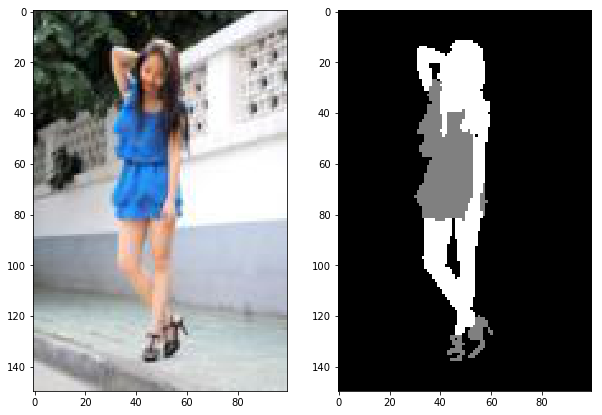

In [21]:

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('humanparsing-4x/valid/imgs/997_399.jpg')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('humanparsing-4x/valid/maps/997_399.png')
plt.imshow(mask, 'gray')

In [3]:
from humanparsing import HumanParsing, fast_hist, per_class_iu
from torch.utils.data import DataLoader

In [4]:
train_data = HumanParsing(data_dir='./humanparsing-4x/train/', augmentation=None)
valid_data = HumanParsing(data_dir='./humanparsing-4x/valid/', augmentation=None)

In [15]:
def flip(x, dim):
    dim = x.dim() + dim if dim < 0 else dim
    return x[tuple(slice(None, None) if i != dim
             else torch.arange(x.size(i)-1, -1, -1).long()
             for i in range(x.dim()))]
train_data_doubled = [];
for i in range(len(train_data)):
    train_data_doubled.append(train_data[i]);
    train_data_doubled.append([flip(train_data[i][0],2),flip(train_data[i][1],1)]);

In [33]:
print('{} images in train set, {} in validation set'.format(len(train_data_doubled), len(valid_data)))

batch_size = 24

train_loader = DataLoader(train_data_doubled, shuffle=True, batch_size=batch_size, num_workers=1)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size, num_workers=1)

29066 images in train set, 1615 in validation set


In [36]:
import time
def iou(prediction,target,classes):
    ret = [];
    for i in range(classes):
        cross = torch.sum((prediction == i) & (target == i));
        square = torch.sum((prediction == i) | (target == i));
        ret.append(cross/square);
    return np.array(ret);
def normalize_set(x):
    for i in range(np.shape(x)[0]):
        for j in range(np.shape(x)[1]):
            x[i,j,:,:] = x[i,j,:,:] - np.min(x[i,j,:,:]);
            x[i,j,:,:] = x[i,j,:,:]/np.max(x[i,j,:,:]);
    return x;
def reduct(y):
    tmp, ret = torch.max(y,1);
    return ret;

#Cross-Entropy loss calculation
def compute_loss_cuda(model,X_batch, y_batch):
    X_batch = Variable(X_batch).cuda()
    y_batch = Variable(y_batch).cuda()
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()
    #return F.nll_loss(logits, y_batch).mean()

#Training function
def train(model,num_epochs,batch_size):
    model.cuda()
    train_loss = []
    #train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, num_workers=1)
    #valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size, num_workers=1)
    #val_accuracy = []
    #opt = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9);
    lr = 0.01;
    opt = torch.optim.Adam(model.parameters(),lr=lr);
    #Full pass over the training data
    
    for epoch in range(num_epochs):
        if (epoch%5) == 0:
            lr /=10;
            opt = torch.optim.Adam(model.parameters(),lr=lr);
        val_accuracy = 0;
        start_time = time.time()
        #Training network mode for dropouts and batchnorms
        model.train(True)
        for X_batch, Y_batch in train_loader:
            # train on batch
            loss = compute_loss_cuda(model,X_batch, Y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.data.cpu().numpy()[0])
            #print('Successfuly done');
        # And a full pass over the validation data:
        model.train(False) # disable dropout / use averages for batch_norm
        i=0;
        for X_batch, Y_batch in valid_loader:
            logits = model(Variable(X_batch).cuda())
            val_accuracy = val_accuracy + iou(reduct(logits.data),Y_batch.cuda(),3);
            i = i + 1;
        display.clear_output(wait=True);
        plt.figure(figsize=(8,6));
        plt.title("Training loss");
        plt.xlabel("# iteration");
        plt.ylabel("loss");
        plt.plot(train_loss,'b');
        plt.show();
        
        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-14533 // batch_size :])))
        print("IoU:")
        print(val_accuracy/i);
        print("mIoU:")
        print(np.mean(val_accuracy/i));

In [37]:
#Creating SqueezeSeg

#Convolution + BatchNorm  ReLU
class myconv(nn.Module):
    def __init__(self, n_in, n_out,n_ker,n_str=1,pad=0,batch=True,relu=True):
        super(myconv, self).__init__()
        self.bbatch = batch;
        self.brelu = relu;
        self.conv = nn.Conv2d(n_in, n_out, n_ker,stride=n_str,padding=pad);
        self.batch = nn.BatchNorm2d(n_out);
        self.relu = nn.ReLU(inplace=True);

    def forward(self, x):
        x = self.conv(x);
        if self.bbatch == True:
            x = self.batch(x);
        if self.brelu == True:
            x = self.relu(x);
        return x

class mydeconv(nn.Module):
    def __init__(self, n_in, n_out,n_ker,n_str=1,pad=1,batch=True,relu=True,opad=0):
        super(mydeconv, self).__init__()
        self.bbatch = batch;
        self.brelu = relu;
        self.deconv = nn.ConvTranspose2d(in_channels=n_in, out_channels=n_out, kernel_size=n_ker,stride=n_str,padding=pad,output_padding=opad);
        self.batch = nn.BatchNorm2d(n_out);
        self.relu = nn.ReLU(inplace=True);

    def forward(self, x):
        x = self.deconv(x);
        if self.bbatch == True:
            x = self.batch(x);
        if self.brelu == True:
            x = self.relu(x);
        return x
    
class myfire(nn.Module):
    def __init__(self,n_in,s11,e11,e33):
        super(myfire, self).__init__()
        self.convinit = myconv(n_in, s11, 1);
        self.conv1 = myconv(s11, e33, 3, pad=1);
        self.conv2 = myconv(s11, e11, 1);
        
    def forward(self, x):
        x = self.convinit(x);
        x1 = self.conv1(x);
        x2 = self.conv2(x);
        return torch.cat([x1, x2],dim=1);

class myfireup(nn.Module):
    def __init__(self,n_in,s11,e11,e33,scale=(2,2),outpad=0):
        super(myfireup, self).__init__()
        self.convinit = myconv(n_in, s11, 1);
        self.decup = mydeconv(s11,s11,3,n_str=scale,opad=outpad);
        self.conv1 = myconv(s11, e33, 3, pad=1);
        self.conv2 = myconv(s11, e11, 1);
        
    def forward(self, x):
        x = self.convinit(x);
        x = self.decup(x);
        x1 = self.conv1(x);
        x2 = self.conv2(x);
        return torch.cat([x1, x2],dim=1);

class SqueezeSeg(nn.Module):
    def __init__(self):
        super(SqueezeSeg, self).__init__()
        self.conv1a = myconv(3,64,3,2,1);
        self.conv1b = myconv(3,64,1);
        self.pool1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2),padding=(1,1));
        self.fire2 = myfire(64,16,64,64);
        self.fire3 = myfire(128,16,64,64);
        self.pool3 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2),padding=(1,1));
        self.fire4 = myfire(128,32,128,128);
        self.fire5 = myfire(256,32,128,128);
        self.pool5 = nn.MaxPool2d(kernel_size=(3,3), stride=(1,1),padding=(1,1));
        self.fire6 = myfire(256,48,192,192);
        self.fire7 = myfire(384,48,192,192);
        self.fire8 = myfire(384,64,256,256);
        self.fire9 = myfire(512,64,256,256);
        self.fire10dec = myfireup(512,64,128,128,scale=(1,1),outpad=(0,0));
        self.fire11dec = myfireup(256,32,64,64,outpad=(1,0));
        self.fire12dec = myfireup(128,16,32,32,outpad=(0,1));
        self.fire13dec = myfireup(64,16,32,32,outpad=(1,1));
        self.conv14 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3,stride=1,padding=1);
        self.relu = nn.LeakyReLU(inplace=True);

    def forward(self, x):
        #return x;  #3x150x100
        x1 = self.conv1b(x);
        #return x1; #32x150x100
        x2 = self.conv1a(x);
        #return x2; #32x75x50
        x = self.pool1(x2);
        #return x;  #32x38x25
        x3 = self.fire2(x);
        #return x3; #64x38x25
        x = self.fire3(x3);
        #return x;  #64x38x25
        x = self.pool3(x);
        #return x;  #64x19x13
        x4 = self.fire4(x);
        #return x4; #128x19x13
        x = self.fire5(x4);
        #return x;  #128x19x13
        x = self.pool5(x);
        #return x;  #128x19x13
        x = self.fire6(x);
        #return x;  #192x19x13
        x = self.fire7(x);
        #return x;  #192x19x13
        x = self.fire8(x);
        #return x;  #256x19x13
        x = self.fire9(x);
        #return x;  #256x19x13
        x = self.fire10dec(x);
        #return x;  #128x19x13
        x = x + x4;
        #return x;  #128x19x13
        x = self.fire11dec(x);
        #return x;  #64x38x25
        x = x + x3;
        #return x;  #64x38x25
        x = self.fire12dec(x);
        #return x;  #32x75x50
        x = x + x2;
        #return x;  #32x75x50
        x = self.fire13dec(x);
        #return x;  #32x150x100
        x = x + x1;
        #return x;  #32x150x100
        x = self.conv14(x);
        x = self.relu(x);
        return x;
    
class SqueezeSeg_small(nn.Module):
    def __init__(self):
        super(SqueezeSeg_small, self).__init__()
        self.conv1a = myconv(3,32,3,2,1);
        self.conv1b = myconv(3,32,1);
        self.pool1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2),padding=(1,1));
        self.fire2 = myfire(32,8,32,32);
        self.fire3 = myfire(64,8,32,32);
        self.pool3 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2),padding=(1,1));
        self.fire4 = myfire(64,16,64,64);
        self.fire5 = myfire(128,16,64,64);
        self.pool5 = nn.MaxPool2d(kernel_size=(3,3), stride=(1,1),padding=(1,1));
        self.fire6 = myfire(128,24,96,96);
        self.fire7 = myfire(192,24,96,96);
        self.fire8 = myfire(192,32,128,128);
        self.fire9 = myfire(256,32,128,128);
        self.fire10dec = myfireup(256,32,64,64,scale=(1,1),outpad=(0,0));
        self.fire11dec = myfireup(128,16,32,32,outpad=(1,0));
        self.fire12dec = myfireup(64,8,16,16,outpad=(0,1));
        self.fire13dec = myfireup(32,8,16,16,outpad=(1,1));
        self.conv14 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3,stride=1,padding=1);
        self.relu = nn.LeakyReLU(inplace=True);
        
    def forward(self, x):
        #return x;  #3x150x100
        x1 = self.conv1b(x);
        #return x1; #32x150x100
        x2 = self.conv1a(x);
        #return x2; #32x75x50
        x = self.pool1(x2);
        #return x;  #32x38x25
        x3 = self.fire2(x);
        #return x3; #64x38x25
        x = self.fire3(x3);
        #return x;  #64x38x25
        x = self.pool3(x);
        #return x;  #64x19x13
        x4 = self.fire4(x);
        #return x4; #128x19x13
        x = self.fire5(x4);
        #return x;  #128x19x13
        x = self.pool5(x);
        #return x;  #128x19x13
        x = self.fire6(x);
        #return x;  #192x19x13
        x = self.fire7(x);
        #return x;  #192x19x13
        x = self.fire8(x);
        #return x;  #256x19x13
        x = self.fire9(x);
        #return x;  #256x19x13
        x = self.fire10dec(x);
        #return x;  #128x19x13
        x = x + x4;
        #return x;  #128x19x13
        x = self.fire11dec(x);
        #return x;  #64x38x25
        x = x + x3;
        #return x;  #64x38x25
        x = self.fire12dec(x);
        #return x;  #32x75x50
        x = x + x2;
        #return x;  #32x75x50
        x = self.fire13dec(x);
        #return x;  #32x150x100
        x = x + x1;
        #return x;  #32x150x100
        x = self.conv14(x);
        x = self.relu(x);
        return x;

In [7]:
seg = SqueezeSeg_small();

In [10]:
train(seg,50,32)

Epoch 1 of 50 took 55.510s
  training loss (in-iteration): 	0.146729
  intersection over union:
[94.9305663  75.30580492 57.47167051]
Epoch 2 of 50 took 55.208s
  training loss (in-iteration): 	0.142766
  intersection over union:
[95.12317018 75.76027513 61.55340953]
Epoch 3 of 50 took 55.188s
  training loss (in-iteration): 	0.140269
  intersection over union:
[95.29917588 76.24468783 61.80002217]
Epoch 4 of 50 took 55.818s
  training loss (in-iteration): 	0.139144
  intersection over union:
[95.32610431 76.47914566 61.73187053]
Epoch 5 of 50 took 56.797s
  training loss (in-iteration): 	0.136094
  intersection over union:
[95.3936866  76.48581151 61.09408306]
Epoch 6 of 50 took 55.409s
  training loss (in-iteration): 	0.134370
  intersection over union:
[95.47854816 77.18666486 63.14299469]
Epoch 7 of 50 took 55.351s
  training loss (in-iteration): 	0.133240
  intersection over union:
[95.39317299 76.47409606 59.7330132 ]
Epoch 8 of 50 took 55.562s
  training loss (in-iteration): 	0.

Process Process-87:
Traceback (most recent call last):
  File "/home/use/anaconda3/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/use/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/use/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 40, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/use/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 40, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/use/Desktop/Iaroslav/DL18 -  Homework 3/humanparsing.py", line 56, in __getitem__
    img, mask = Image.open(img).convert('RGB'), Image.open(mask).convert('I')
  File "/home/use/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2439, in open
    im = _open_core(fp, filename, prefix)
  File "/home/use/anaconda3/lib/python3.6/site

KeyboardInterrupt: 

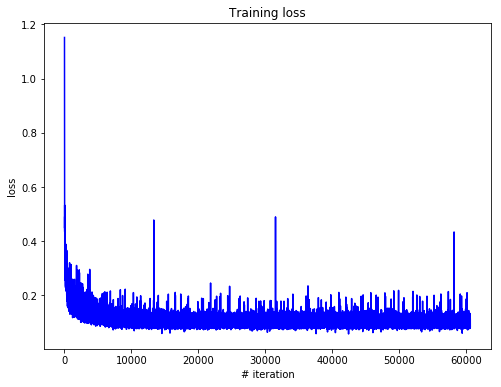

Epoch 50 of 50 took 179.691s
  training loss (in-iteration): 	0.101294
IoU:
[0.96600452 0.81422745 0.68688551]
mIoU:
0.8223724950940863


In [40]:
train(seg,50,24)

## Report 

At the time of 3rd homework I also had to do an admission test task for Yandex summer internship. The task was to apply SqueezeSeg for lidar images objects segmentation. So here I just used that network with minor improvements and it works just fine. 

### Preprocessing

Embarking on a great adventure, one needs quite an extensive preparation, so I devote this chapter to a peculiar concoction of truly ingenious transformations applied by me to the input images. 

In this task as a preprocessing I applied only horizontal flip to double the image dataset. But without it the network also works fine.

I used Adam with learning rate started from 0.1 and changed by the factor of 10 every 10 epochs. It worked slightly better than Adam with constant learning rate of 0.01. To compute loss (loss function) I used cross entropy loss, i.e. log SoftMax + NLL loss. I also tried (1-mIoU) loss function, but it did not work for me.

    
### Methods

Congratulations, adventurer! Here, we've reached the heart of my report: a discussion of algorithms and the effect of input image transforms. Let me be your guide, for the experiment setup is dank and full or errors. 

I bring an architecture of network from here https://arxiv.org/pdf/1710.07368.pdf. So I used exactly that architecture but without CRF. Then I changed some things. The first one what I changed was downsampling in MaxPooling layers. In article authors downsample only in horizontal direction by the factor of 2. I downsampled in both hoizontal and vertical directions by the factor of 2. Then I examined output sizes of all operations inside the network and tuned boundary parameters to satisfy sizes. Also I noticed that after 2 MaxPooling downsamplings image size becomes too small (19x13), so I  I added BatchNormalization after each convolutional+relu layer. Also I did not use softmax at the last layer of the network, except that I used leakyReLU for evaluation and log SoftMax for training (inside cross_entropy loss).

At the first part I constructed SqueezeSeg with 2 times less layers than in original network. The network was trained easily and with that I achieved slightly less than 0.8 mIoU. At this step I also did not use flipped images for training. At the second part I evaluated full size network but with still original dataset. I tried different learning rates and optimizes, but the best results were achieved with Adam and decreasing learninfg rate by the factor of 10 every 10 epochs. Overlall network is thrained correctly after 50 epochs. With that I achieved 0.81 mIoU. Then I increased dataset by flipping images and retrained network. The results were quiet impressive, I achieved 0.822 mIoU. I do not really know weather authors of SqueezeSeg used BatchNorm or no, but I used. Also I changed the last layer from softmax to leakuReLU because softmax is computed during training and with softmax in the last layer network performs worse. 

    
### Conclusions

Even the best of things must come to an end! Like every good story, this one is not without a clever lesson for the youth, so here's what I've learned while on my quest for a perfect segmentation...

1) Implement SqueezeSeg without CRF.

2) Change last layer from SoftMax to LeakyReLU.

3) Compute loss by cross-entropy function.

4) Larger network works better than smaller one (half size of channels number) by about 5% in mIoU. 

5) Network trains much better with dataset doubled by horizontally flipped images by about 2% in mIoU.
 
???????

PROFIT!!!